## Enunciado
Considere la información del proyecto cuya información aparece en la tabla adjunta:  

1.  Calcule los tres diagramas de Gantt correspondientes al análisis de valor ganado.
2.  Calcule EV, PV, AC, CPI y SPI para el punto de control actual.
3.  Calcule utilizando el método de MonteCarlo la duración media y la desviación típica del resto de proyecto que falta por completar. Suponga para ello que la duración aleatoria de las actividades ya empezadas es proporcional a su duración planificada original.


In [1]:
import os, sys
from jupyter_tikz import TexFragment

"""
USANDO_COLAB =True
if USANDO_COLAB:
    !apt install libgraphviz-dev              > /dev/null
    %pip install pygraphviz "pandas[excel]"   > /dev/null
    %pip install numpyarray_to_latex          > /dev/null

    repo_url = 'https://github.com/mcasl/pmULE'
    repo_name = "pmULE"


    if not os.path.exists(repo_name):
        print(f"Cloning repository '{repo_name}'...")
        !git clone {repo_url}
        print("Repository cloned successfully!")
    else:
        print(f"Good! No need to download '{repo_name}' again.")

    from google.colab import files
    sys.path.append('pmULE/src')
else:
  sys.path.append('src')
"""
sys.path.append('pmULE/src')
from pmule import PredecessorTable, ProjectGraph, EarnedValue
os.chdir("/Users/mcasl/temp/")

In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.display import display, HTML, Math, Latex, Markdown
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, desviación, coste_planificado, coste_real, duracion_real, realizado
     ('A',      '---    ',       2,          0.5,         60,              80,          2,           100,   ),
     ('B',      '---    ',       2,          0.2,         60,              60,          3,           100,   ),
     ('C',      '---    ',       3,          0.6,         60,              80,          4,           100,   ),
     ('D',      'A      ',       4,          0.1,         40,              60,          5,           100,   ),
     ('E',      'A      ',       1,          0.3,         30,              36,          3,           100,   ),
     ('F',      'E, B   ',       2,          0.7,         12,              12,          3,           100,   ),
     ('G',      'E, B   ',       1,          0.2,         39,              54,          3,           100,   ),
     ('H',      'G, C   ',       4,          0.3,         36,              72,          2,            50,   ),
     ('I',      'D, F   ',       1,          0.7,         90,              90,          2,            60,   ),
     ('J',      'D, F, H',       2,          0.3,         50,               0,          0,             0,   ),
     ('K',      'D, F, H',       2,          0.9,         40,               0,          0,             0,   ),
     ('L',      'I, J   ',       2,          0.3,         30,               0,          0,             0,   ),
     ('M',      'K      ',       2,          0.6,         30,               0,          0,             0,   ),
] ,columns=['actividad', 'precedentes', 'duracion', 'desviacion',
            'coste_planificado', 'coste_real', 'duracion_real', 'realizado']).set_index('actividad')
datos_enunciado

,precedentes,duracion,desviacion,coste_planificado,coste_real,duracion_real,realizado
actividad,,,,,,,
A,---,2,0.5,60,80,2,100
B,---,2,0.2,60,60,3,100
C,---,3,0.6,60,80,4,100
D,A,4,0.1,40,60,5,100
E,A,1,0.3,30,36,3,100
F,"E, B",2,0.7,12,12,3,100
G,"E, B",1,0.2,39,54,3,100
H,"G, C",4,0.3,36,72,2,50
I,"D, F",1,0.7,90,90,2,60


In [3]:
numero_de_muestras = 10

nombres_de_actividades = datos_enunciado.index
np.random.seed(2025)
duraciones_montecarlo = pd.DataFrame([np.random.normal(size = numero_de_muestras,
                                                       loc  = datos_enunciado.duracion[task],
                                                       scale= datos_enunciado.desviacion[task])
                                      for task in nombres_de_actividades],
                                     index=nombres_de_actividades).T.round(1)

In [4]:
duraciones_montecarlo

actividad,A,B,C,D,E,F,G,H,I,J,K,L,M
0,2.0,1.8,4.0,3.9,1.3,1.9,1.2,3.6,0.1,2.2,3.3,2.4,2.4
1,2.4,1.8,2.9,3.9,0.6,1.0,0.8,4.5,0.1,2.0,3.6,1.8,1.5
2,1.3,1.8,2.9,4.0,1.6,1.5,0.7,3.6,0.9,1.8,1.4,2.4,2.2
3,1.7,2.0,3.4,3.9,0.8,1.1,0.8,3.9,-0.5,2.1,2.8,2.2,3.2
4,1.9,2.0,3.0,4.1,0.6,2.6,0.9,4.1,1.0,1.8,2.5,2.3,1.7
5,3.1,1.6,3.5,4.0,1.5,2.8,0.8,3.8,0.5,1.8,1.6,2.0,2.2
6,2.7,2.2,3.1,4.0,1.4,1.3,1.2,3.7,1.2,1.8,1.8,1.7,1.1
7,1.9,2.0,3.0,3.9,1.3,1.9,1.0,4.1,0.9,2.1,3.0,1.9,2.6
8,2.4,2.0,3.7,4.0,0.8,2.3,0.7,3.5,1.6,2.0,0.6,1.3,2.6
9,2.1,1.9,3.0,4.1,1.3,1.2,1.1,4.3,0.4,1.4,2.7,1.8,1.6


{{< pagebreak >}}

### Apartado 1

>1. Calcule los tres diagramas de Gantt correspondientes al análisis de valor ganado.

In [5]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M
activities,,,,,,,,,,,,,
A,,,,,,,,,,,,,
B,,,,,,,,,,,,,
C,,,,,,,,,,,,,
D,True,,,,,,,,,,,,
E,True,,,,,,,,,,,,
F,,True,,,True,,,,,,,,
G,,True,,,True,,,,,,,,
H,,,True,,,,True,,,,,,
I,,,,True,,True,,,,,,,


La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

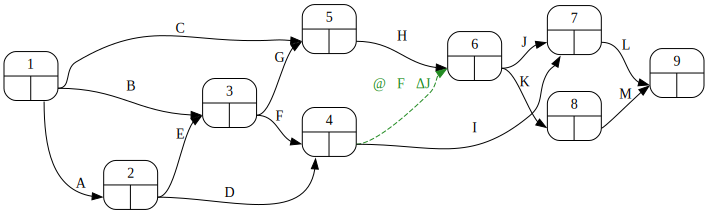

In [6]:
proyecto = prelaciones.create_project()
proyecto.pert()

#### Gantt Valor Planificado

In [7]:
vg = EarnedValue(proyecto)

In [8]:
gantts = vg.calcula_gantts(datos_proyecto,
                           planned_durations_label    = 'duracion',
                           actual_durations_label     = 'duracion_real',
                           PV_label                   = 'coste_planificado',
                           AC_label                   = 'coste_real',
                           percentage_complete_label  = 'realizado'
                          )

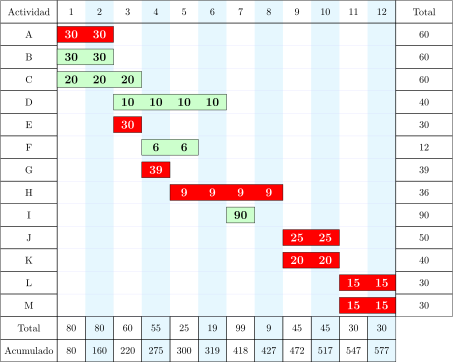

In [9]:
TexFragment(gantts['gantt_PV']).run_latex()

#### Gantt Valor Ganado

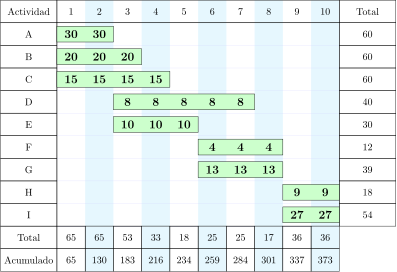

In [10]:
TexFragment(gantts['gantt_EV']).run_latex()

#### Gantt Coste Real

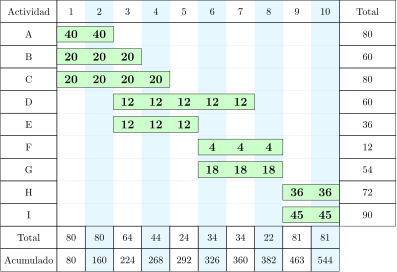

In [11]:
TexFragment(gantts['gantt_AC']).run_latex()

### Apartado 2
> 2. Calcule EV, PV, AC, CPI y SPI para el punto de control actual sin ayudarse de los gráficos de Gantt.


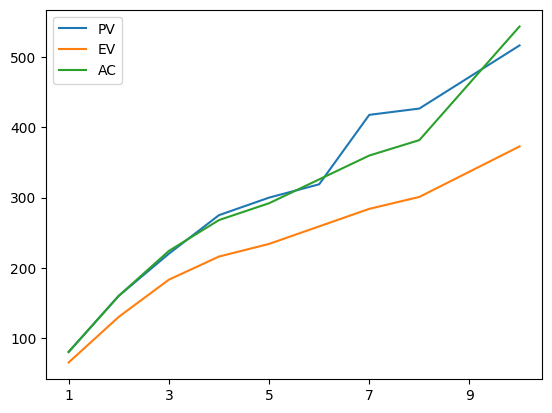

In [12]:
acumulados = gantts['acumulados']
acumulados.plot();

In [13]:
acumulados.tail(1)

,PV,EV,AC
10,517.0,373.0,544.0


In [14]:
EV = acumulados.tail(1)['EV'].iloc[0]
AC = acumulados.tail(1)['AC'].iloc[0]
PV = acumulados.tail(1)['PV'].iloc[0]
CPI = EV/AC
SPI=EV/PV

In [15]:
Markdown(f"Se obtiene CPI=EV/AC={round(CPI,2)} y SPI=EV/PV={round(SPI,2)}")

Se obtiene CPI=EV/AC=0.69 y SPI=EV/PV=0.72

### Apartado 3

> 3. Calcule utilizando el método de MonteCarlo la duración media y la desviación típica del resto de proyecto que falta por completar. Suponga para ello que la duración aleatoria de las actividades ya empezadas se calcula de manera proporcional a su duración aleatoria planificada original.


#### Fragmento de proyecto por realizar

In [16]:
prelaciones_restantes = PredecessorTable.from_dict_of_strings(
    { 'H': '',
      'I': '',
      'J': 'H',
      'K': 'H',
      'L': 'I, J',
      'M': 'K'
    }
    )


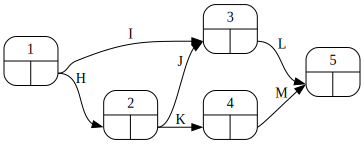

In [17]:
proyecto_restante = prelaciones_restantes.create_project()
proyecto_restante.pert(duraciones=False)

#### Cálculo de las duraciones del resto del proyecto

In [18]:
datos_proyecto_restante = datos_proyecto.copy().drop(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
restantes = datos_proyecto_restante.query('realizado != 100')
duraciones_montecarlo = duraciones_montecarlo.reindex(restantes.index, axis=1)
duraciones_montecarlo = duraciones_montecarlo.eval('H = H * 0.5')
duraciones_montecarlo = duraciones_montecarlo.eval('I = I * 0.4')
duraciones_montecarlo

actividad,H,I,J,K,L,M
0,1.80,0.04,2.2,3.3,2.4,2.4
1,2.25,0.04,2.0,3.6,1.8,1.5
2,1.80,0.36,1.8,1.4,2.4,2.2
3,1.95,-0.20,2.1,2.8,2.2,3.2
4,2.05,0.40,1.8,2.5,2.3,1.7
5,1.90,0.20,1.8,1.6,2.0,2.2
6,1.85,0.48,1.8,1.8,1.7,1.1
7,2.05,0.36,2.1,3.0,1.9,2.6
8,1.75,0.64,2.0,0.6,1.3,2.6
9,2.15,0.16,1.4,2.7,1.8,1.6


#### Cálculo de la duración del proyecto

La matrix de rutas es

In [19]:
proyecto_restante.path_matrix(dummies=False)

,H,I,J,K,L,M
Route_1,1,0,1,0,1,0
Route_2,1,0,0,1,0,1
Route_3,0,1,0,0,1,0


Multiplicando la matriz de rutas por las duraciones de las actividades, obtenemos las duraciones de las rutas en cada iteración.

In [20]:
duraciones_caminos =  proyecto_restante.path_matrix(dummies=False) @ duraciones_montecarlo.T
duraciones_caminos

,0,1,2,3,4,5,6,7,8,9
Route_1,6.40,6.05,6.00,6.25,6.15,5.7,5.35,6.05,5.05,5.35
Route_2,7.50,7.35,5.40,7.95,6.25,5.7,4.75,7.65,4.95,6.45
Route_3,2.44,1.84,2.76,2.00,2.70,2.2,2.18,2.26,1.94,1.96


Considerando en cada iteración el máximo de las duraciones de las rutas obtenemos los valores de las duraciones del proyecto.

In [21]:
duraciones_proyecto = pd.DataFrame(duraciones_caminos.max(axis="rows"))
duraciones_proyecto.columns=['Duración']
duraciones_proyecto

,Duración
0,7.50
1,7.35
2,6.00
3,7.95
4,6.25
5,5.70
6,5.35
7,7.65
8,5.05
9,6.45


Con estos valores podemos describir la distribución de la duración del proyecto a través de su media y desviación típica.

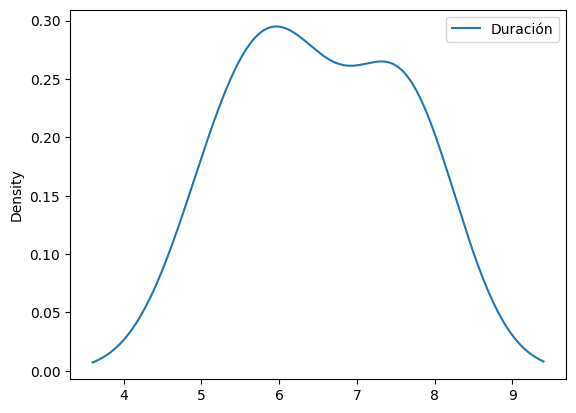

In [22]:
duraciones_proyecto.plot(kind='density');

In [23]:
Markdown(f"La duración media es {round(float(duraciones_proyecto.mean().iloc[0]), 2)}")

La duración media es 6.53

In [24]:
Markdown(f"La desviación típida es {round(float(duraciones_proyecto.std().iloc[0]), 2)}")

La desviación típida es 1.03